## Data Import 

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('House_Price.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature Processing 

In [5]:
object_column = data.select_dtypes(include = ['object']).columns.tolist()

In [6]:
label_encoder = preprocessing.LabelEncoder()

for column in object_column:
    data[column]= label_encoder.fit_transform(data[column])

In [7]:
data.corr() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,1.000000,0.011156,-0.006096,-0.010601,-0.033226,0.008916,-0.001530,0.032122,-0.019659,0.013324,...,0.057044,-0.033928,-0.000399,0.037057,-0.006242,0.021172,0.000712,0.019773,-0.005806,-0.021917
MSSubClass,0.011156,1.000000,0.035900,-0.386347,-0.139781,-0.024969,-0.105995,0.119289,-0.002940,-0.022844,...,0.008283,-0.005221,0.086360,0.034859,-0.007683,-0.013585,-0.021407,0.012464,-0.024940,-0.084284
MSZoning,-0.006096,0.035900,1.000000,-0.111690,-0.034452,0.087654,-0.052039,0.061887,-0.017854,-0.001192,...,-0.003128,0.002882,-0.061289,0.000673,0.009293,-0.031496,-0.020628,0.097437,0.009494,-0.166872
LotFrontage,-0.010601,-0.386347,-0.111690,1.000000,0.426095,-0.040886,0.138101,-0.169641,-0.080757,NaN,...,0.206167,-0.195051,-0.040862,-0.006629,0.003368,0.011200,0.007450,-0.034559,0.063372,0.351799
LotArea,-0.033226,-0.139781,-0.034452,0.426095,1.000000,-0.197131,0.060105,-0.165315,-0.149083,0.010123,...,0.077672,-0.065167,0.036031,-0.103544,0.038068,0.001205,-0.014261,0.012292,0.034169,0.263843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,0.021172,-0.013585,-0.031496,0.011200,0.001205,0.003690,0.013094,-0.033455,-0.011599,-0.051552,...,-0.033737,0.036368,-0.009892,-0.014193,-0.006495,1.000000,-0.145721,-0.047386,0.013320,0.046432
YrSold,0.000712,-0.021407,-0.020628,0.007450,-0.014261,-0.025043,0.020944,0.036449,0.020507,0.023353,...,-0.059689,0.060904,-0.035366,-0.055962,0.004906,-0.145721,1.000000,-0.002327,0.003880,-0.028923
SaleType,0.019773,0.012464,0.097437,-0.034559,0.012292,0.014339,0.008205,-0.000911,-0.025754,-0.126770,...,0.011009,-0.013592,-0.006154,-0.003311,0.015773,-0.047386,-0.002327,1.000000,0.184067,-0.054911
SaleCondition,-0.005806,-0.024940,0.009494,0.063372,0.034169,0.006064,0.035717,-0.038118,0.033809,-0.089701,...,-0.067251,0.097425,0.100675,0.003192,0.013027,0.013320,0.003880,0.184067,1.000000,0.213092


<AxesSubplot:>

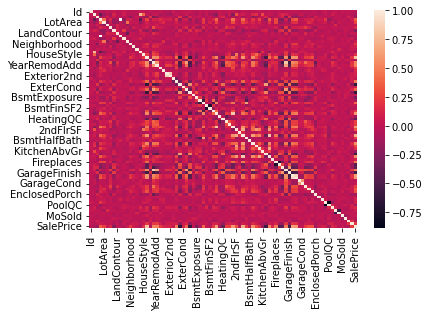

In [44]:
sns.heatmap(data.corr())

In [41]:
threshold = 0.7

df_corr = data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = data.columns[~columns]
high_correlation = data[selected_columns]

In [65]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [43]:
selected_columns

Index(['BldgType', 'Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [48]:
high_correlation.corr()

,BldgType,Exterior2nd,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice
BldgType,1.000000,-0.142748,-0.073688,-0.198413,0.200367,-0.061421,-0.085591
Exterior2nd,-0.142748,1.000000,0.017361,0.068503,0.155058,0.095006,0.103766
1stFlrSF,-0.073688,0.017361,1.000000,0.409516,0.233449,0.489782,0.605852
TotRmsAbvGrd,-0.198413,0.068503,0.409516,1.000000,0.148112,0.337822,0.533723
GarageYrBlt,0.200367,0.155058,0.233449,0.148112,1.000000,0.564567,0.486362
GarageArea,-0.061421,0.095006,0.489782,0.337822,0.564567,1.000000,0.623431
SalePrice,-0.085591,0.103766,0.605852,0.533723,0.486362,0.623431,1.000000


/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


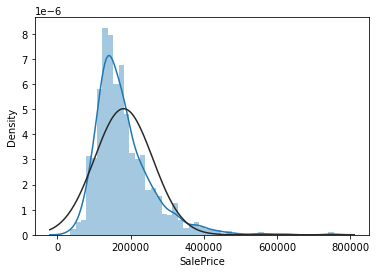

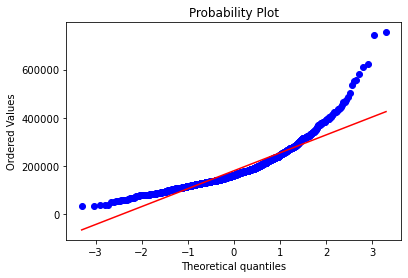

In [71]:
from scipy.stats import norm
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


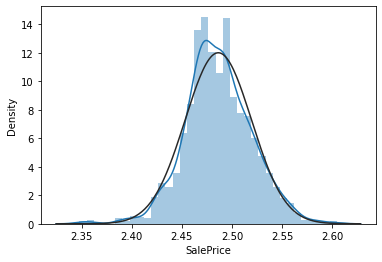

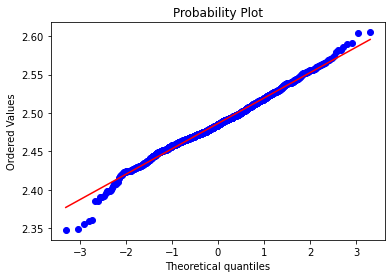

In [73]:
data['SalePrice'] = np.log(data['SalePrice'])
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

## Random Forest Model 

In [94]:
data = data.dropna()
X = data.drop(['SalePrice', 'Id'], axis = 'columns')
y = data['SalePrice']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train);

In [98]:
rf.feature_names_in_

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDriv

<BarContainer object of 79 artists>

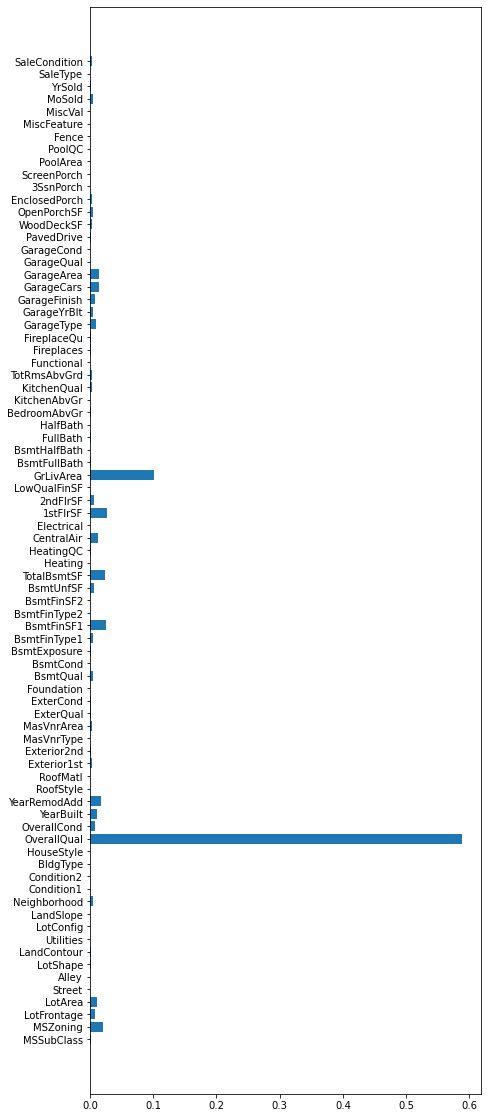

In [104]:
plt.figure(figsize=(7, 20))
plt.barh(rf.feature_names_in_, rf.feature_importances_)